In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [12]:
from dotenv import load_dotenv
load_dotenv()
import os
google_api_key = os.getenv('GOOGLE_API_KEY')
if not google_api_key: 
    raise ValueError("GOOGLE_API_KEY is not set in the environment variables.")

from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [13]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

In [7]:
graph = graph_builder.compile()

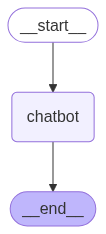

In [8]:
graph

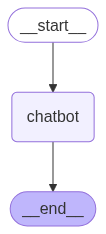

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Okay, let's break down how to get started with LangGraph coding.  LangGraph is a powerful library for building conversational agents (like chatbots) with complex, stateful logic and branching conversations.  Here's a structured approach, covering the key concepts and steps:

**1. Understanding the Core Concepts**

Before diving into the code, it's crucial to grasp the fundamental ideas behind LangGraph:

*   **Nodes:** These are the building blocks of your graph. Each node represents a step in the conversation or a unit of processing.  Nodes can be:
    *   **LLMs (Language Model Nodes):**  Call a language model (like GPT-3/4, PaLM, Llama, etc.) to generate text, answer questions, or perform tasks.
    *   **Tools:**  Use external tools (search engines, calculators, databases) to augment the LLM's capabilities.
    *   **Python Functions:**  Run arbitrary Python code to manipulate data, perform calculations, or interact with APIs.
*   **Edges:**  Edges define the flow of inf

In [15]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - GeeksforGeeks',
   'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'content': 'LangGraph is a Python library that helps you build applications like chatbots or AI agents by organizing their logic step-by-step using state machine model. This step configures your Gemini API key and then we create a simple function `ask_gemini` that takes user input, sends it to the Gemini model and returns the AI-generated response. Creates a state structure with three fields: `question`, `classification` and `response` which flows through the LangGraph. import matplotlib.pyplot as plt from langgraph.graph import StateGraph\u200bbuilder = StateGraph(GraphState)builder.add_node("classify", classify)builder.add_node("respond", respond)builder.set_entry_point("classify")builder.add_edge("classify", "respond")builder.set_finish_po

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

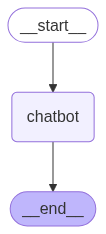

In [18]:
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)
graph

In [19]:
config = {"configurable": {"thread_id": "1"}}

In [20]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's nice to meet you. How can I help you today?


In [21]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will! I remember your name.


In [22]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

As a large language model, I don't have memory of past conversations. So, I don't remember your name. You'll need to tell me again!


In [23]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='0f9a235a-dad4-44c4-92c1-628e6ebdd753'), AIMessage(content="Hi Will! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--250302f4-45ea-497d-aa8a-bb034cb4f5f8-0', usage_metadata={'input_tokens': 8, 'output_tokens': 19, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2d1b71d7-a2ac-4df1-b16c-05a4e6af28a0'), AIMessage(content='Yes, Will! I remember your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--7257b71d-2164-

In [24]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

In [27]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [30]:
from langgraph.prebuilt import ToolNode, tools_condition
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

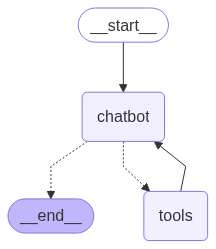

In [32]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
graph

In [33]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (566b89c7-ba2d-4b90-8ed0-94d1e032aa51)
 Call ID: 566b89c7-ba2d-4b90-8ed0-94d1e032aa51
  Args:
    query: I need some expert guidance for building an AI agent.


In [34]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [35]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (566b89c7-ba2d-4b90-8ed0-94d1e032aa51)
 Call ID: 566b89c7-ba2d-4b90-8ed0-94d1e032aa51
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph to build your agent. They say it's more reliable and extensible than simple autonomous agents.
